# Preparação de dados

Agora, iremos preparar os dados que temos até o momento para uso nos algorítmos de aprendizado de máquina, começando pela importação das bibliotecas necessárias e dos dados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
data = pd.read_csv('../csv-data/explorado_houses_to_rent_v2.csv')
data.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent amount,property tax,fire insurance,total,city_Belo Horizonte,city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo
0,70,2,1,1,7,1,1,2065,3300,211,42,5618,0,0,0,0,1
1,320,4,4,0,20,1,0,1200,4960,1750,63,7973,0,0,0,0,1
2,80,1,1,1,6,1,0,1000,2800,0,41,3841,0,0,1,0,0
3,51,2,1,0,2,1,0,270,1112,22,17,1421,0,0,1,0,0
4,25,1,1,0,1,0,0,0,800,25,11,836,0,0,0,0,1


Iremos prosseguir dividindo nossos dados usando a função `train_test_split`

In [3]:
data = data.sample(frac=1.0, random_state=0).reset_index(drop=True)
X = data.drop('total', axis = 1)
y = data['total']

X = pd.DataFrame(X, index=X.index, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

Agora, iremos fazer o scaling dos dados usando o `StandardScaler` do scikit learn

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Teste e seleção de modelos

Iremos definir a seguir um dicionário com os modelos candidatos para a resolução do problema proposto

In [5]:
models = {
    "Ridge":{"model":Ridge() },
    "SVR": {"model": SVR()},
    "DecisionTreeRegressor":{"model":DecisionTreeRegressor() },
    "LinearRegression":{"model":LinearRegression() },
    "Lasso":{"model":Lasso() },
    "RandomForestRegressor":{"model":RandomForestRegressor() },
    "AdaBoostRegressor":{"model":AdaBoostRegressor() },
    "MLPRegressor":{"model":MLPRegressor() },
    "GradientBoostingRegressor":{"model":GradientBoostingRegressor() },
    "KNeighborsRegressor": {"model": KNeighborsRegressor()}
}

Agora iremos percorrer o dicionário e fazer alguns usando os modelos escolhidos.
Iremos medir o tempo de treinamento e tirar o R2 score e o RMSE de cada modelo.
O modelo com os melhores resultados será escolhido para a resolução do problema, por melhor, definiremos como:

- Menor tempo de treinamento
- Menor RMSE
- Maior R2 score

In [6]:
result_list = []

for name, model_item in models.items():
    model = model_item['model']
    model.fit(X_train,y_train)
    
    # Cross validation
    result = cross_validate(model, X_train,y_train, cv = 5, scoring='neg_mean_squared_error')
    
    # RMSE
    RMSE = [(-x)**0.5 for x in result['test_score']]
    RMSE = int(sum(RMSE)/len(RMSE))
    
    # Training time
    training_time = round(sum(result['fit_time']) / len(result['fit_time']), 4)
    
    # R2 score
    score = r2_score(y_test,model.predict(X_test))
        
    result_list.append([name, RMSE, score, training_time])
    
df_results = pd.DataFrame(result_list, columns = ['model','RMSE', 'r2_score', 'training_time'])
df_results.sort_values(by=['RMSE', 'r2_score'], ascending=True, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

/home/lgc/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lgc/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lgc/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lgc/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lgc/anaconda3/lib/python3.11/site-packages

,model,RMSE,r2_score,training_time
0,LinearRegression,4,1.000000,0.0038
1,Lasso,6,0.999999,0.0114
2,Ridge,6,0.999999,0.0034
3,GradientBoostingRegressor,180,0.998570,1.0851
4,RandomForestRegressor,209,0.996436,3.4938
5,DecisionTreeRegressor,323,0.993198,0.0515
6,KNeighborsRegressor,727,0.969245,0.0012
7,AdaBoostRegressor,851,0.955774,0.5410
8,MLPRegressor,1319,0.943875,3.8726
9,SVR,4039,0.046190,3.0131


Podemos ver na tabela acima que uma regressão linear parece ser um bom candidato de modelo para este problema, a seguir, iremos visualizar os resultados dos testes utilizando gráficos.

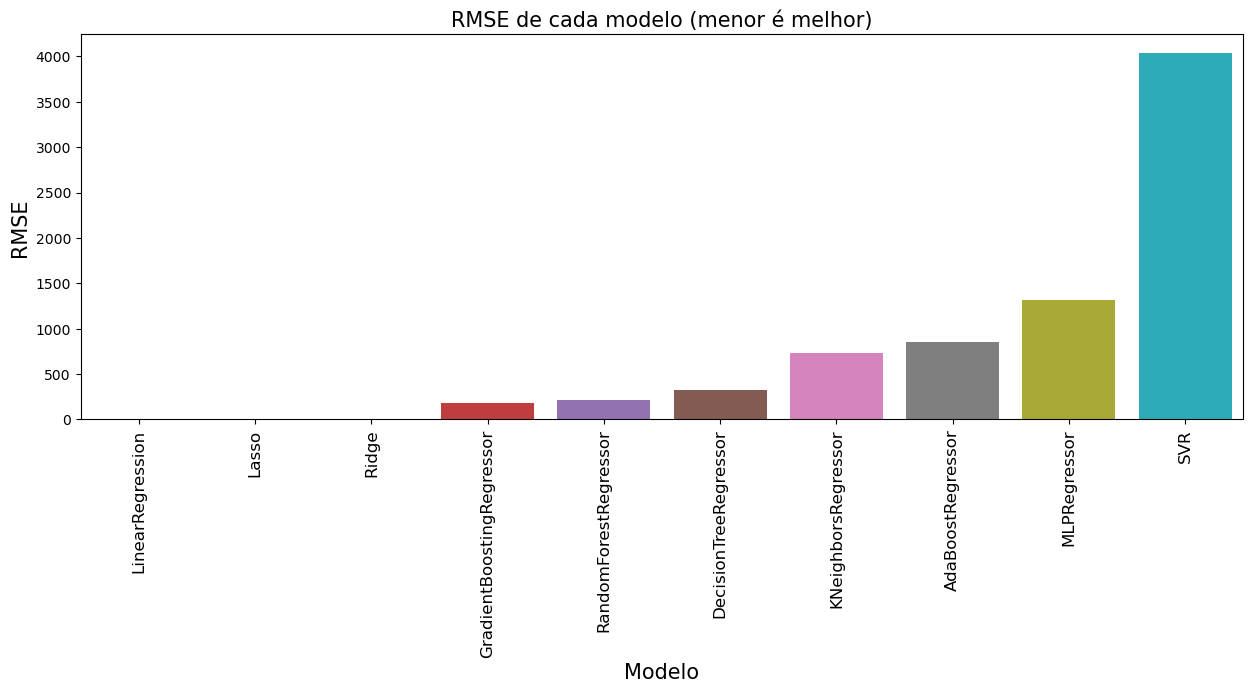

In [7]:
def gen_barplot(y, order, title, xlabel, ylabel):
    plt.figure(figsize = (15,5))
    sns.barplot(x = 'model', y = y, data = df_results, order = order)
    plt.title(title, fontsize = 15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.xticks(rotation=90, fontsize=12)
    plt.show()
    
gen_barplot('RMSE', 
            df_results.sort_values("RMSE")["model"], 
            'RMSE de cada modelo (menor é melhor)',
           'Modelo',
            'RMSE'
           )

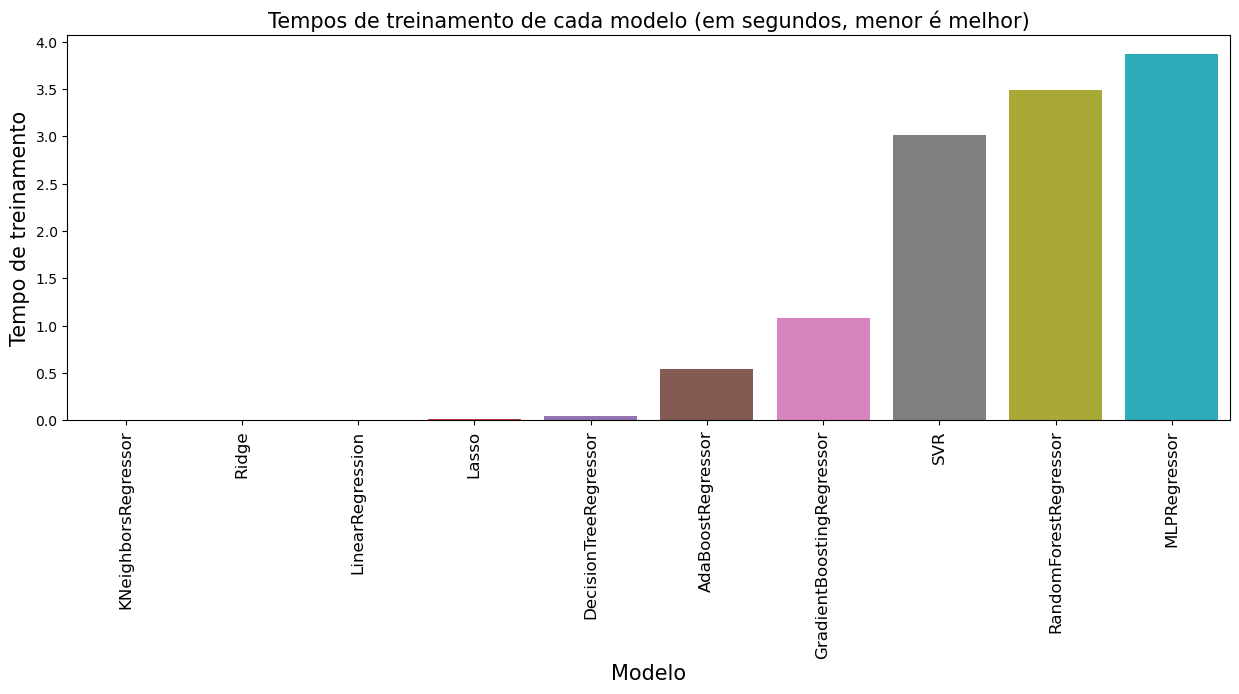

In [8]:
gen_barplot(
    'training_time', df_results.sort_values("training_time")["model"],
    'Tempos de treinamento de cada modelo (em segundos, menor é melhor)',
    'Modelo', 'Tempo de treinamento'
)

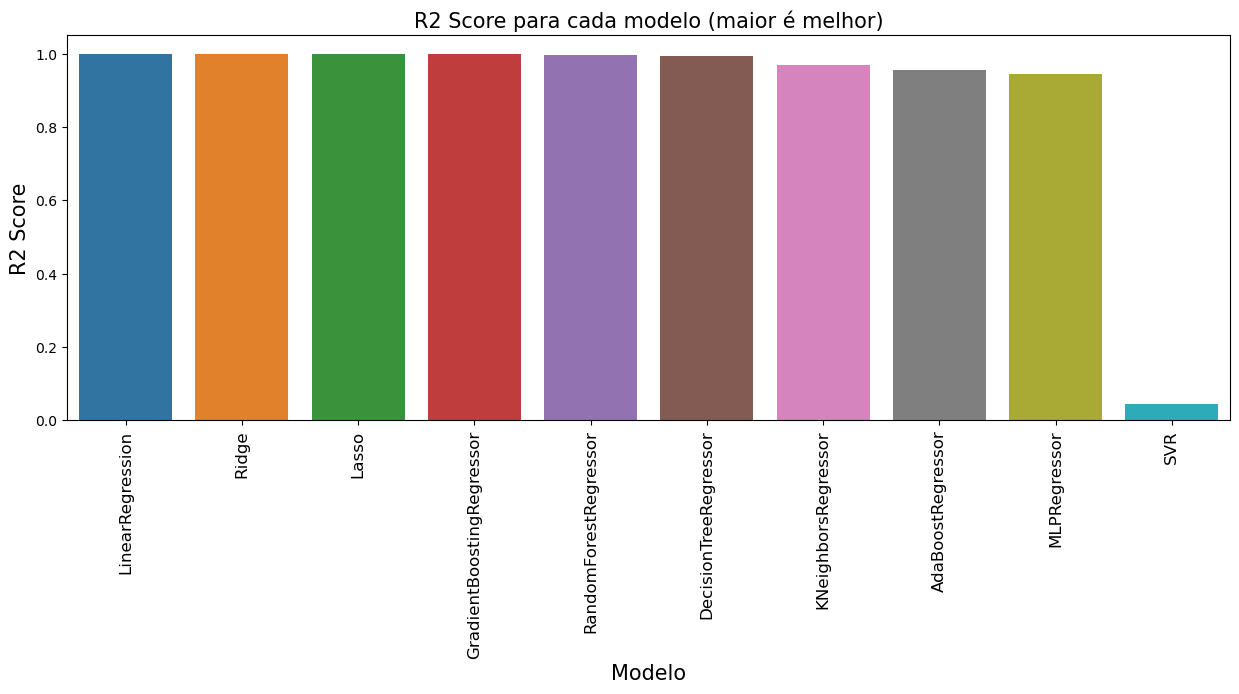

In [9]:
gen_barplot('r2_score',
            df_results.sort_values("r2_score", ascending = False)["model"],
           'R2 Score para cada modelo (maior é melhor)',
            'Modelo', 'R2 Score' 
           )

# Avaliação do modelo e resultados

Com o modelo de regressão linear escolhido, iremos treinar e montar as predições do modelo, inicialmente comparando com os valores reais separados para teste.

In [10]:
best_model = df_results.iloc[0]

model = models[best_model[0]]['model']
model.fit(X_train,y_train)

pred = model.predict(X_test)

pred_s = pd.Series(pred)
y_test_s = y_test.reset_index(drop=True)

df_result = pd.concat([y_test_s,round(pred_s,0)], axis = 1)
df_result.columns = ['Valor de teste', 'Predição']
df_result = df_result.astype({'Predição': 'int64'})

diff = df_result[df_result['Valor de teste'] != df_result['Predição']].size
print(f'Valores com diferença: {diff}/{df_result.size} ({((diff/df_result.size) * 100).round(2)}%)')

df_result

Valores com diferença: 730/4050 (18.02%)


,Valor de teste,Predição
0,2553,2553
1,7774,7775
2,1174,1174
3,2557,2557
4,4684,4684
...,...,...
2020,5372,5372
2021,1602,1602
2022,5370,5370
2023,6144,6144


Podemos fazer uma melhor visualização utilizando alguns gráficos, a seguir, temos um box plot e um gráfico de linhas comparando os resultados das predições com os valores de teste reais:

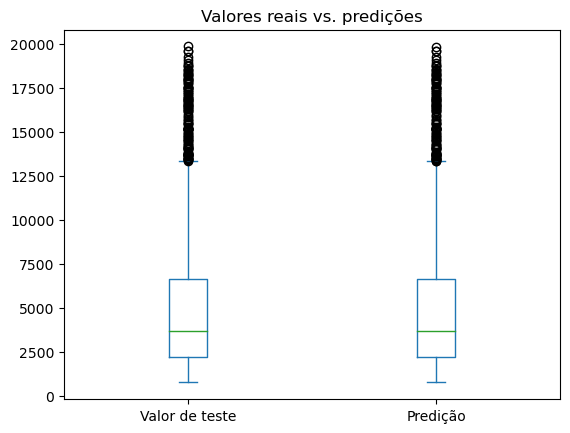

In [11]:
df_result.plot.box()
plt.title('Valores reais vs. predições', fontsize = 12)
plt.show()

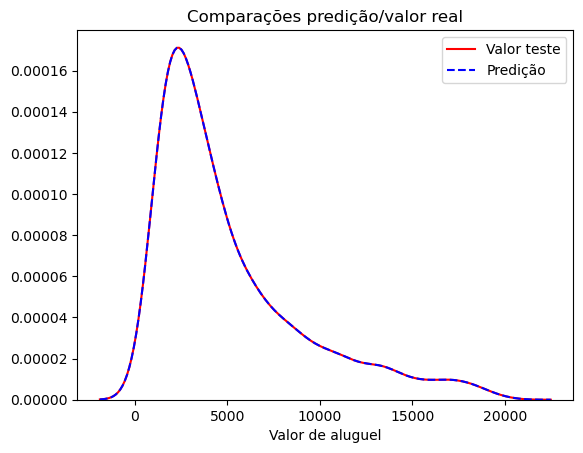

In [12]:
model = models[best_model["model"]]["model"]
model.fit(X_train,y_train)

ax1 = sns.kdeplot(y_test,color ="r",label ="Valor teste")
ax_final = sns.kdeplot(model.predict(X_test),color ="b",ax =ax1, linestyle="--",label ="Predição")

plt.xlabel('Valor de aluguel')
plt.ylabel('')
plt.title('Comparações predição/valor real')
plt.legend()
plt.show()

Podemos notar que temos bons resultados a partir dos gráficos acima, pois os gráficos demonstrando os resultados das predições são notoriamente similares aos gráficos que demonstram os valores reais (ambos box plots e linhas sobrepondo-se).